<h1><center> DIABETES: KNN MODEL</center></h1>

__Author__:

1. David Montaño Castro.

Given 2 traits (level of glucose and bloodpressure), I am aiming at trying to classify whether someone has diabetes or not. 

Packages required
---

In [1]:
### Pre procesing
import pandas as pd
import numpy as np

### Visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Modeling
from matplotlib import cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from mlxtend.plotting import plot_decision_regions
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_confusion_matrix
import matplotlib.cm as cm

# Adjustments
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
pd.set_option('display.max_columns', 90)

Import DataSet
---

In [2]:
ill = pd.read_csv("T2_diabetes.csv");ill.head(5)

,glucose,bloodpressure,diabetes
0,40,85,0
1,40,92,0
2,45,63,1
3,45,80,0
4,40,73,1


General information
---

### Structure

There is only 995 rows and 3 columns, including the target one. 

In [3]:
ill.shape

(995, 3)

### Data types
All columns correspond to int64 data dypes.

In [4]:
ill.dtypes

glucose          int64
bloodpressure    int64
diabetes         int64
dtype: object

### NaN or Null values.
There is neither Nan nor Null values. There is no need to replace any value. 

In [5]:
ill.isna().sum().where(lambda x: x>0).dropna()

Series([], dtype: float64)

### Describe
Pertaining to diabetes column, notice that at least 50% of data correponds to 1 values (True diabetes diagnostic). Stds are relatively small.

In [6]:
ill.describe().T

,count,mean,std,min,25%,50%,75%,max
glucose,995.0,44.306533,6.707567,20.0,40.0,45.0,50.0,70.0
bloodpressure,995.0,79.184925,9.340204,50.0,72.0,80.0,87.0,100.0
diabetes,995.0,0.500503,0.500251,0.0,0.0,1.0,1.0,1.0


Data visualization
---

### Glucose
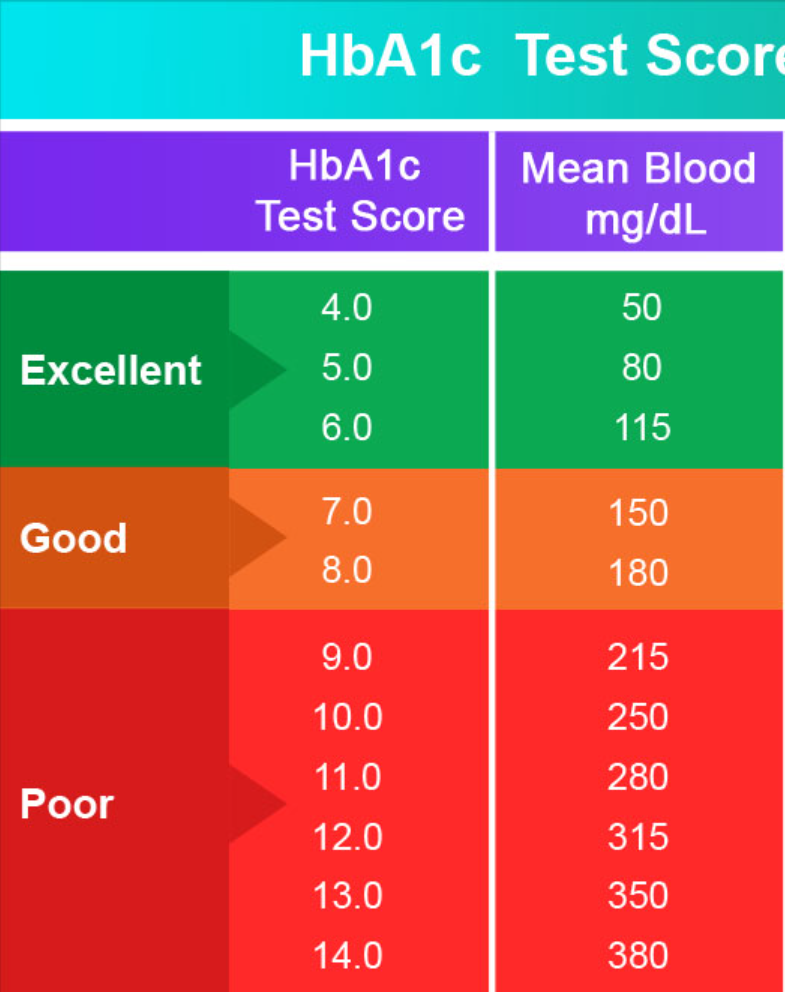

Very symetric distribution and poor skewness. 50% of data belongs to the 40 - 50 interval, which is considered as "normal". Two outliers stands out.

45    365
40    264
50    162
35     68
55     64
30     27
60     22
25     10
65      8
20      3
70      2
Name: glucose, dtype: int64


Text(0.5, 0, 'Level of Glucose')

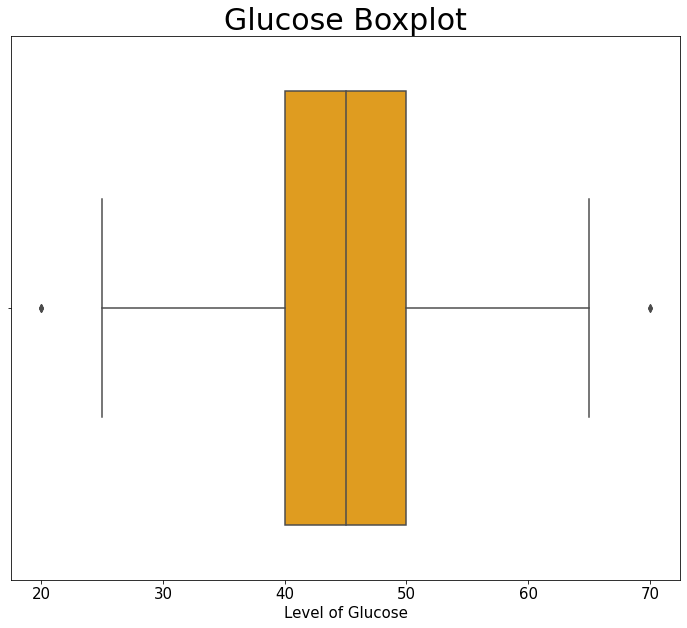

In [7]:
print(ill.glucose.value_counts())
sns.boxplot(ill.glucose, color = "orange")
plt.title("Glucose Boxplot", size = 30)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Level of Glucose", size = 15)

Glucose's histograms allows to visualize a high kurtosis (leptokurtic) and the presence of purely integer values. According to value counts and this representation, mode equals 45.

Text(0.5, 0, 'Level of Glucose')

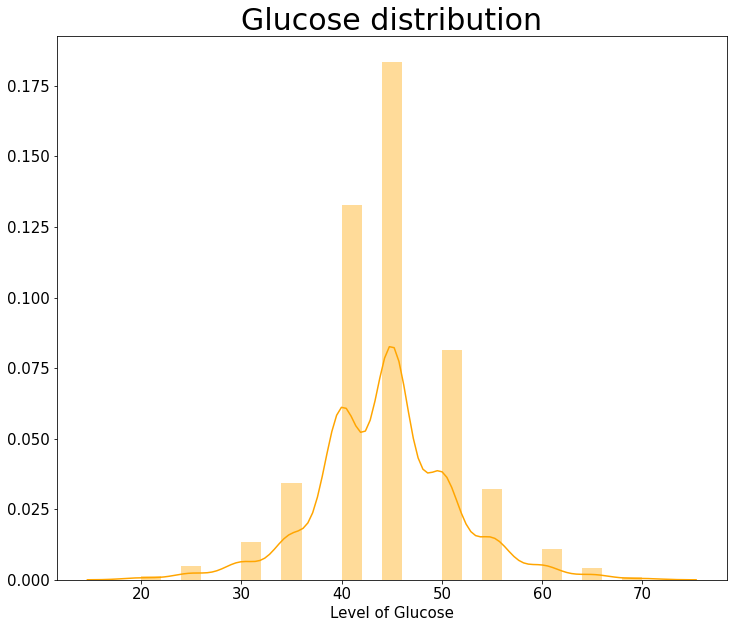

In [8]:
sns.distplot(ill.glucose, color = "orange")
plt.title("Glucose distribution", size = 30)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Level of Glucose", size = 15)

### Bloodpressure
A negative biased distribution. Bloodpressuere ranging from 50 to 100 units, in which 50% of the data belongs to 73 - 87 interval. Median equals to 80 and mode equals 88, which is largely explain due to a negative biased distribution. There is no outliers. 

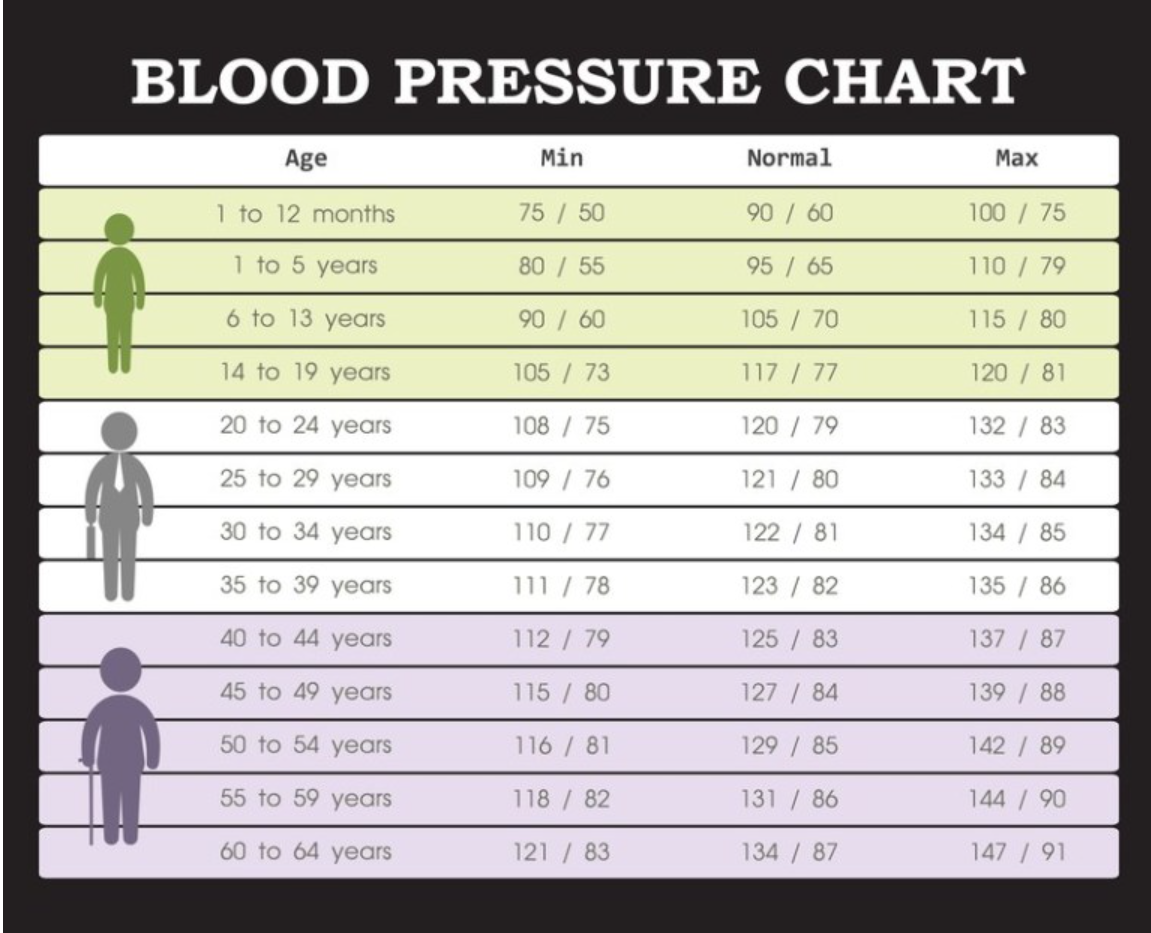

88     75
85     70
87     69
83     66
73     62
90     61
75     51
82     49
68     48
80     47
70     47
78     46
67     44
77     42
92     42
72     41
65     32
93     25
63     20
95     14
62     12
60     12
97      6
57      4
58      4
100     2
98      2
52      1
50      1
Name: bloodpressure, dtype: int64


Text(0.5, 0, 'Level of B. pressure')

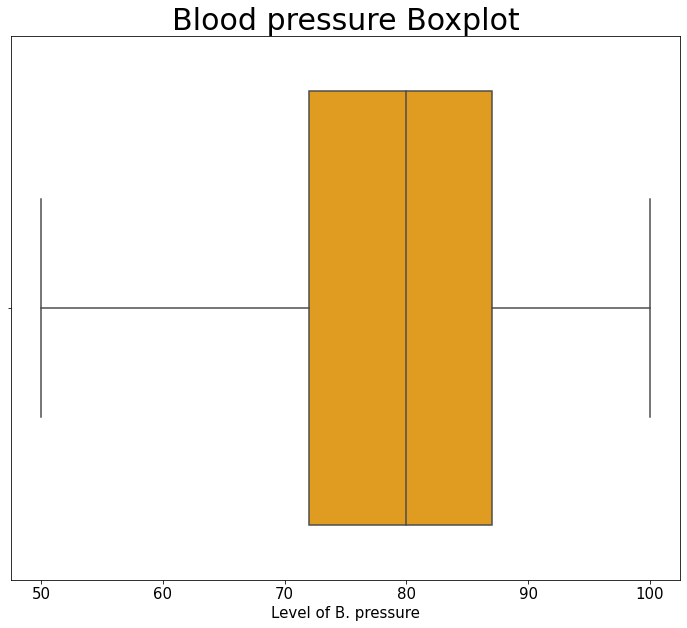

In [9]:
print(ill.bloodpressure.value_counts())
sns.boxplot(ill.bloodpressure, color = "orange")
plt.title("Blood pressure Boxplot", size = 30)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Level of B. pressure", size = 15)

Text(0.5, 0, 'Level of B. pressure')

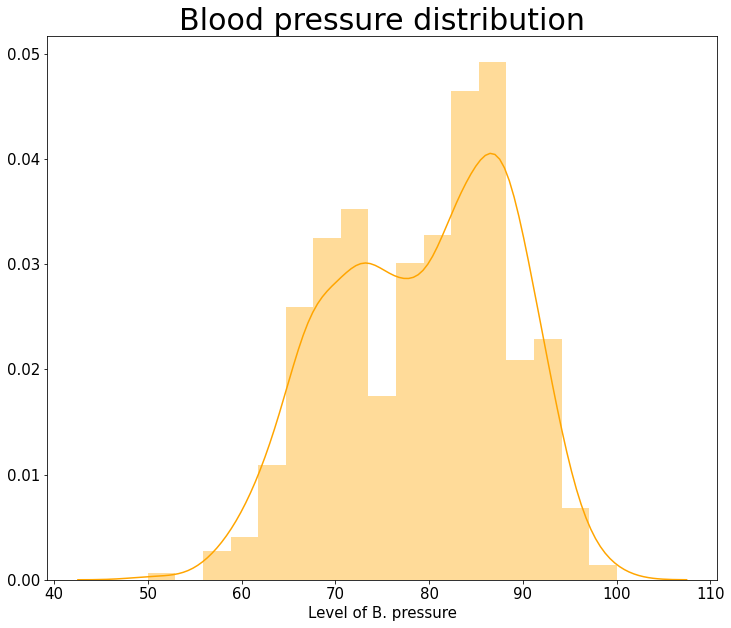

In [10]:
sns.distplot(ill.bloodpressure, color = "orange")
plt.title("Blood pressure distribution", size = 30)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Level of B. pressure", size = 15)

### Are glucose and bloodpressure correlated?
As regards to possible correlation between independent variables, There is no critical correlation which is ideal.

In [11]:
ill.drop(columns = ["diabetes"]).corr()

,glucose,bloodpressure
glucose,1.000000,-0.164553
bloodpressure,-0.164553,1.000000


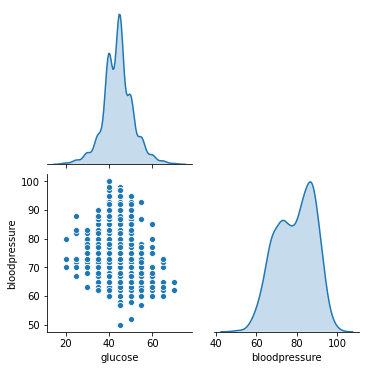

In [12]:
sns.pairplot(ill.drop('diabetes', axis=1), diag_kind="kde", corner=True)

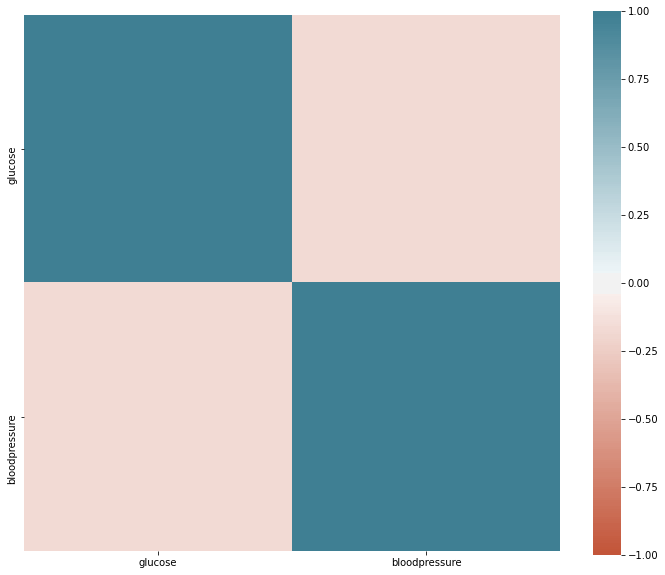

In [13]:
sns.heatmap(
    ill.drop(columns = ["diabetes"]).corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

Split the data into Train/Test
---

In [14]:
X = ill.drop(columns = ["diabetes"])
Y = ill.diabetes
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size = 0.2, random_state = 0)

### Scale variables
As I will be working with KNN model, it is imperative to scale numeric values in order to improve its efficency since it works with measures. In lights of the presence of a few _outliers_,  MinMaxScaler should work best; StandarScaler should work as well though.

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Choosing k value
There are two different ways to calculate the optimal k value: Comparing mean square values and comparing accuracy values. Since mean square values may be misleading, accuracy turns out to be a better option.    

As previously seen in the plot above, taking a small enough k value will provide better results because most of the data is all gathered. 

Results seem to be accurate according to previous statement: 3,7,9,12,18,19 are k values that privide better accuracy results; stil, the optimal  k value corresponds to k = 3. Neverthless, we are ask to test 3 different k values, therefore I am to be chosing 3, 13 and 19.

([<matplotlib.axis.XTick at 0x232f17f2be0>,
 <a list of 19 Text major ticklabel objects>)

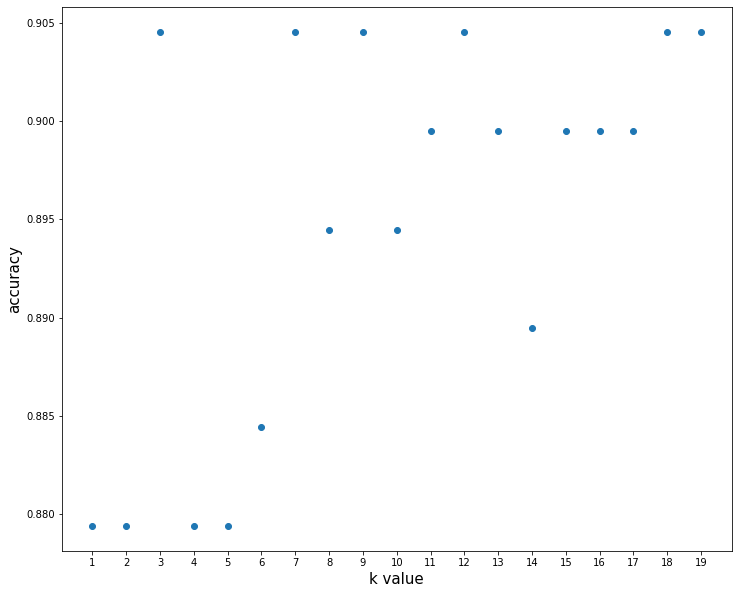

In [16]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, Y_train)
    scores.append(knn.score(X_test, Y_test))
plt.figure()
plt.xlabel('k value', size = 15)
plt.ylabel('accuracy', size = 15)
plt.scatter(k_range, scores)
plt.xticks(list(k_range))

Modeling
---
Carrying out Cross Validation entails better results. I am goint to be taking just 5 folds for each K value.

### K = 3

In [17]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train,Y_train)
Y_pred = knn3.predict(X_test)

#### Mean Square Error
Might result misleading.

In [18]:
mean_squared_error(Y_test,Y_pred)

0.09547738693467336

#### Score 
Correct Answers ratio in train split.

In [19]:
round(knn3.score(X_train, Y_train)*100,2)

95.1

#### Accuracy
Correct Answers ratio in test split.

In [20]:
round(metrics.accuracy_score(Y_test, Y_pred) * 100,2)

90.45

#### Confusion Matrix
The model can slightly better identify positive cases (reducing type 2 error). One is more concern about reducing False Negative Values pertaining to deseases such as diabetes. 9% of positive cases where predicted as negative cases.    

In [21]:
tn,fp,fn,tp = confusion_matrix(Y_test,Y_pred).ravel()
(tn,fp,fn,tp)

(79, 9, 10, 101)

In [22]:
confusion_matrix(Y_test,Y_pred)

array([[ 79,   9],
       [ 10, 101]], dtype=int64)

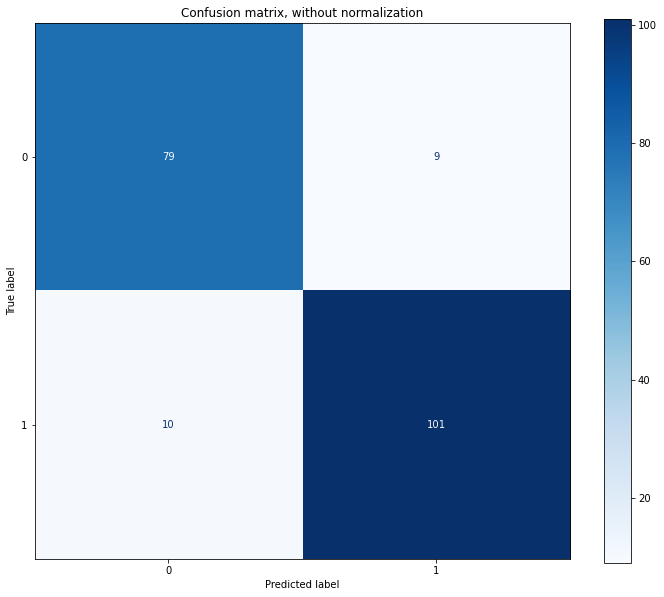

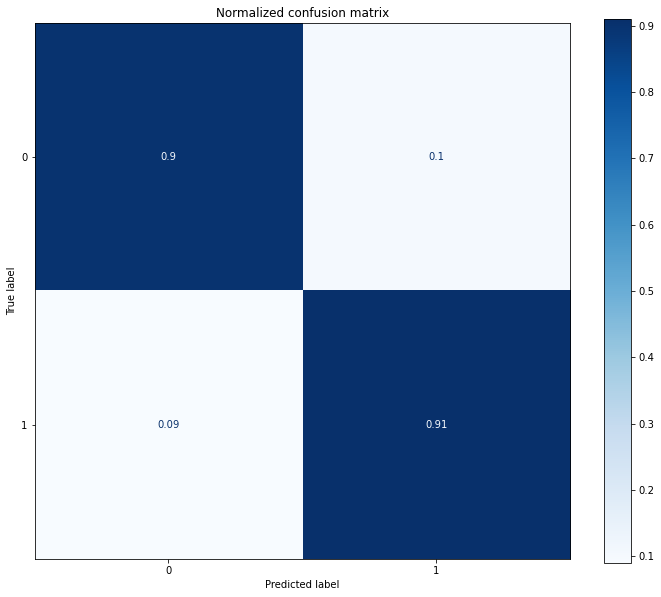

In [23]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn3, X_test, Y_test,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

#### Decision regions
__NOTA: No encontré cómo resolver ese problema. En Stack sale que tengo que mover algo en contour pero no logré dar con el__

C:\Users\actda\anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:244: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,


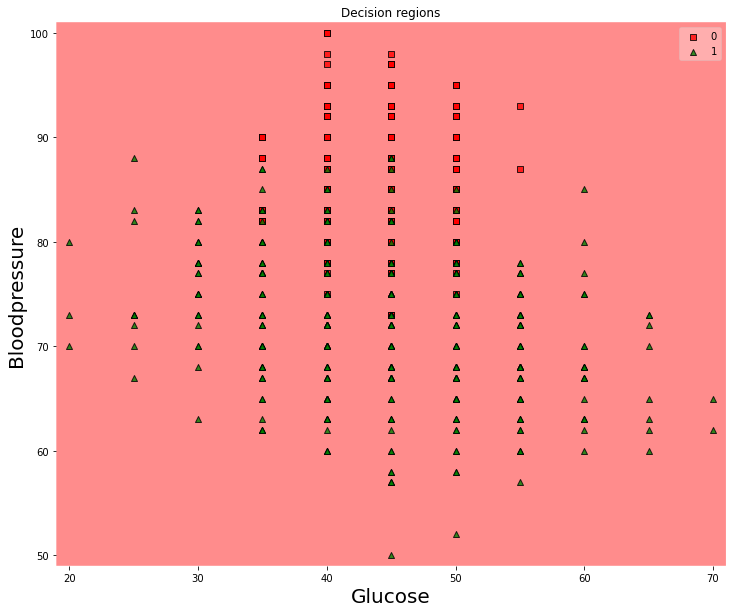

In [24]:
Xdum = ill[["glucose","bloodpressure"]]
X3 = np.asarray(Xdum)
Y3 = np.asarray(Y)

ax = plot_decision_regions(X3,Y3, clf=knn3, legend=2,
                           colors='red,green')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [0,1],
          framealpha=0.3, scatterpoints=1)
plt.title('Decision regions')
plt.xlabel('Glucose', size = 20)
plt.ylabel('Bloodpressure', size = 20)
# ax.invert_xaxis()
plt.show()

### K = 13

In [25]:
knn13 = KNeighborsClassifier(n_neighbors=13)
knn13.fit(X_train,Y_train)
Y_pred = knn13.predict(X_test)

#### Mean Square Error
Might result misleading.

In [26]:
mean_squared_error(Y_test,Y_pred)

0.10050251256281408

#### Score 
Correct Answers ratio in train split.

In [27]:
round(knn3.score(X_train, Y_train)*100,2)

95.1

#### Accuracy
Correct Answers ratio in test split.

In [28]:
round(metrics.accuracy_score(Y_test, Y_pred) * 100,2)

89.95

#### Confusion Matrix
The model can slightly better identify positive cases (reducing type 2 error). One is more concern about reducing False Negative Values pertaining to deseases such as diabetes. 9% of positive cases where predicted as negative cases.    

In [29]:
tn,fp,fn,tp = confusion_matrix(Y_test,Y_pred).ravel()
(tn,fp,fn,tp)

(79, 9, 11, 100)

In [30]:
confusion_matrix(Y_test,Y_pred)

array([[ 79,   9],
       [ 11, 100]], dtype=int64)

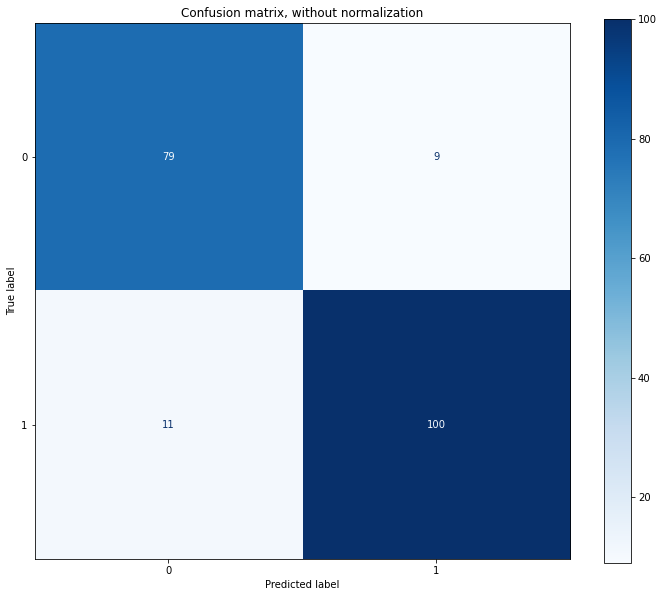

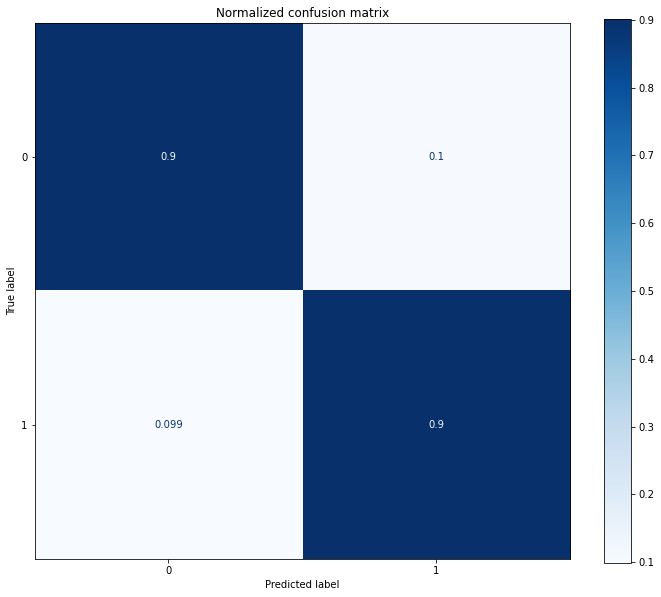

In [31]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn13, X_test, Y_test,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

### K = 19

In [32]:
knn19 = KNeighborsClassifier(n_neighbors=19)
knn19.fit(X_train,Y_train)
Y_pred = knn19.predict(X_test)

#### Mean Square Error
Might result misleading.

In [33]:
mean_squared_error(Y_test,Y_pred)

0.09547738693467336

#### Score 
Correct Answers ratio in train split.

In [34]:
round(knn19.score(X_train, Y_train)*100,2)

93.72

#### Accuracy
Correct Answers ratio in test split.

In [35]:
round(metrics.accuracy_score(Y_test, Y_pred) * 100,2)

90.45

#### Confusion Matrix
The model can slightly better identify positive cases (reducing type 2 error). One is more concern about reducing False Negative Values pertaining to deseases such as diabetes. 9% of positive cases where predicted as negative cases.    

In [36]:
tn,fp,fn,tp = confusion_matrix(Y_test,Y_pred).ravel()
(tn,fp,fn,tp)

(84, 4, 15, 96)

In [37]:
confusion_matrix(Y_test,Y_pred)

array([[84,  4],
       [15, 96]], dtype=int64)

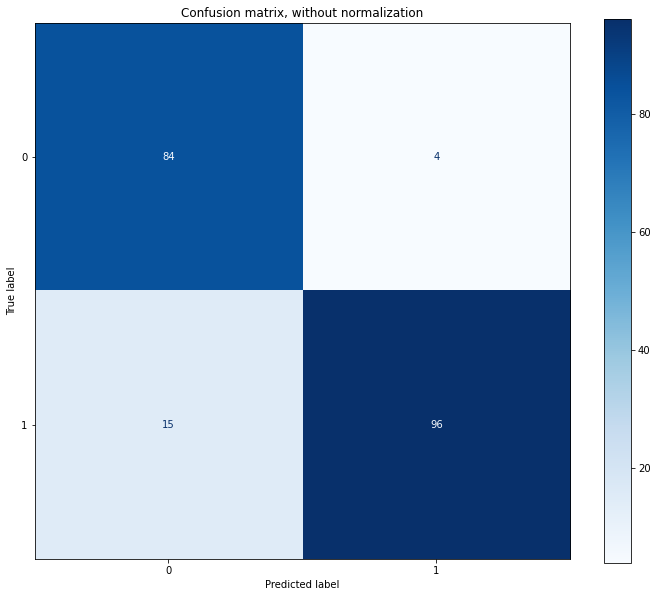

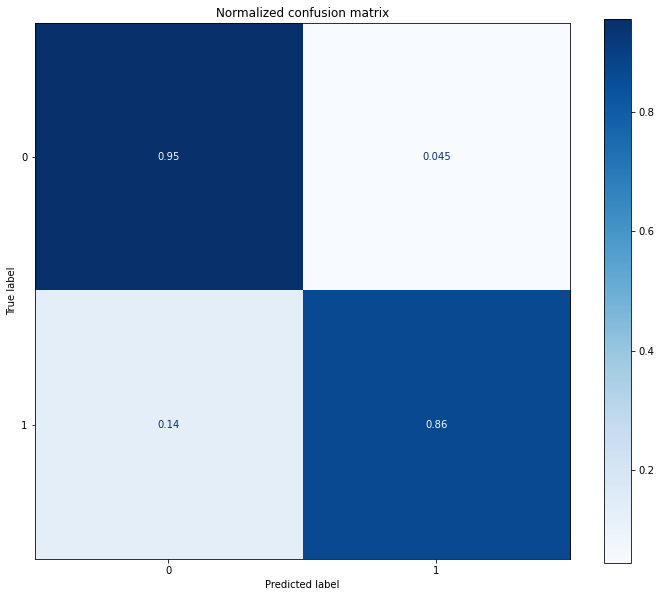

In [38]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn19, X_test, Y_test,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

Conclusions
---

As it was expected, K = 3 improves a lot the model. Even though K = 3 and K = 19 have the same mean square error, we are aiming at shrinking False Negatives Cases and K = 3 does it best. 

Regarding to Score values, K = 3 and K = 13 are tied while K = 19 is less efficient. Noneless, Accuracy values are higher in both K = 3 and K = 19 models. 

To conclude, K = 3 is the best k value to take into account to reduce as much as possible 2 type error.   